In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pandas
import numpy
import plotnine
from hetmech.hetmat import HetMat
import hetmech.degree_weight
import tqdm
import scipy.sparse
import scipy.stats
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
c1 = plt.cm.Set1(0)
c2 = plt.cm.Set1(1)
c3 = plt.cm.Set1(2)

In [4]:
import sys
sys.path.insert(0, 'bulk-pipeline/')
import pipeline

In [5]:
hetmat = HetMat('../data/hetionet-v1.0.hetmat/')
hetmech.degree_weight.default_dwwc_method = hetmech.degree_weight.dwwc_recursive

In [6]:
metapaths = hetmat.metagraph.extract_metapaths(source='D', target='G', max_length=2)

len(metapaths)

27

In [7]:
permat = hetmat.permutations['001']

In [8]:
def combine_dwpc_dgp(hetmat, metapath, permat):
    """
    Combine DWPC information with degree-grouped permutation summary metrics.
    Save resulting tables as one-per-metapath, compressed .tsv files.
    """
    stats_path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                           'degree-grouped-permutations', f'{metapath}.tsv')
    degree_stats_df = pandas.read_table(stats_path)

    dwpc_row_generator = hetmech.degree_group.dwpc_to_degrees(permat, metapath)
    dwpc_df = pandas.DataFrame(dwpc_row_generator)
    df = (
        dwpc_df
        .merge(degree_stats_df, on=['source_degree', 'target_degree'])
        .drop(columns=['source_degree', 'target_degree'])
        .rename(columns={'mean': 'p-dwpc', 'sd': 'sd-dwpc'})
    )
    df['r-dwpc'] = df['dwpc'] - df['p-dwpc']
    df['z-dwpc'] = df['r-dwpc'] / df['sd-dwpc']
    return df

In [9]:
permutation_df = combine_dwpc_dgp(hetmat, metapaths[0], permat)

In [10]:
hetionet_df = combine_dwpc_dgp(hetmat, metapaths[0], hetmat)

In [11]:
merged_df = hetionet_df.merge(permutation_df, on=['source_id', 'target_id'], suffixes=('-het', '-perm'))

In [12]:
merged_df.head(2)

,dwpc-het,path-count-het,source_id,source_name-het,target_id,target_name-het,n-het,nnz-het,n_perms-het,p-dwpc-het,...,path-count-perm,source_name-perm,target_name-perm,n-perm,nnz-perm,n_perms-perm,p-dwpc-perm,sd-dwpc-perm,r-dwpc-perm,z-dwpc-perm
0,0.0,0,DOID:0050156,idiopathic pulmonary fibrosis,1,A1BG,10337625,0,25,0.0,...,0,idiopathic pulmonary fibrosis,A1BG,10337625,0,25,0.0,0.0,0.0,NaN
1,0.0,0,DOID:0050156,idiopathic pulmonary fibrosis,2,A2M,10337625,0,25,0.0,...,0,idiopathic pulmonary fibrosis,A2M,10337625,0,25,0.0,0.0,0.0,NaN


In [13]:
select_metapaths = ['DtC', 'DaGiG', 'DrDtC', 'CcSEcCtD']

In [14]:
metapath = select_metapaths[1]
# metapath = 'DaGcG'

In [15]:
row, col, dwpc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=1)

dwpc_values = dwpc_matrix.toarray().flatten()

In [16]:
permutation_matrices = dict()

for name, permat in tqdm.tqdm_notebook(hetmat.permutations.items()):
    row, col, perm_dwpc = hetmech.degree_weight.dwpc(permat, metapath, dense_threshold=1)
    permutation_matrices[name] = perm_dwpc

HBox(children=(IntProgress(value=0, max=125), HTML(value='')))

### Distributions of unscaled DWPCs and permuted DWPCs

In [17]:
perms = np.vstack([i.toarray().flatten() for i in permutation_matrices.values()]).T
path_nnz = (perms != 0).sum(axis=1)

In [18]:
sum_perms = perms.sum(axis=1)

In [19]:
len(hetmat.permutations)

125

In [20]:
e_nnz = np.mean(path_nnz[path_nnz != 0])
np.mean(path_nnz), e_nnz

(11.328604461110347, 21.446567378450666)

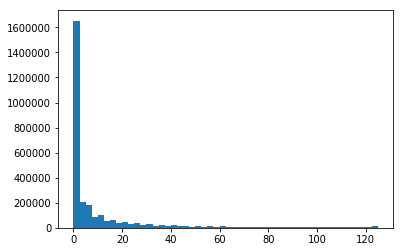

In [21]:
plt.hist(path_nnz, bins=50);

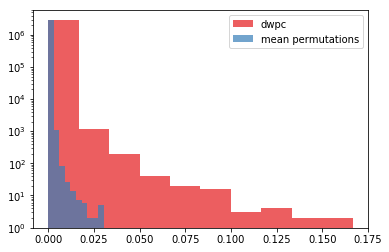

In [22]:
# Path mean DWPC across all permutations
mean_values = np.mean(perms, axis=1)

plt.hist(dwpc_values, color=c1, label='dwpc', alpha=0.7)
plt.hist(mean_values, color=c2, label='mean permutations', alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.legend()

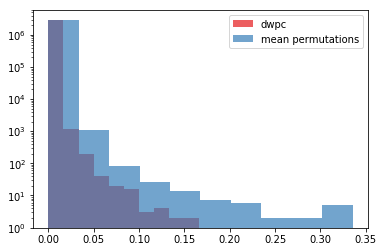

In [23]:
# Path DWPC sum across permutations divided by mean NNZ per path
mean_values = sum_perms / np.mean(path_nnz)

plt.hist(dwpc_values, color=c1, label='dwpc', alpha=0.7)
plt.hist(mean_values, color=c2, label='mean permutations', alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.legend()

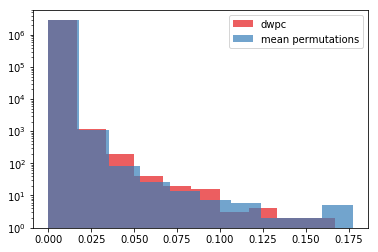

In [24]:
# Path DWPC sum divided by expected path NNZ for paths having at least one nonzero DWPC permutation
mean_values = sum_perms / e_nnz

plt.hist(dwpc_values, color=c1, label='dwpc', alpha=0.7)
plt.hist(mean_values, color=c2, label='mean permutations', alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.legend()

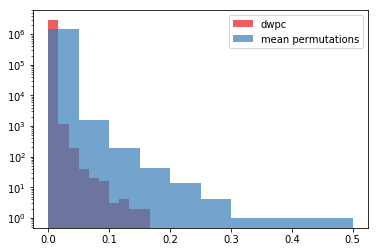

In [25]:
# Scale the sum of permuted DWPC by the NNZ permutations for that path
mean_values = sum_perms[path_nnz != 0] / path_nnz[path_nnz != 0]

plt.hist(dwpc_values, color=c1, label='dwpc', alpha=0.7)
plt.hist(mean_values, color=c2, label='mean permutations', alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.legend()

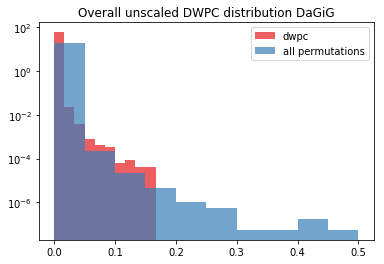

In [26]:
# Normalized histogram of all DWPC values for hetionet and all 45 permutations
plt.hist(dwpc_values, color=c1, density=True, label='dwpc', alpha=0.7)
plt.hist(perms.flatten(), color=c2, density=True, label='all permutations', alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.title(f'Overall unscaled DWPC distribution {metapath}')
plt.legend()

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


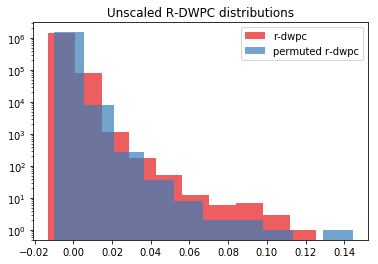

In [27]:
perm_dwpc = perms.T[0]
p_dwpc = perms.T[1:].mean(axis=0)
r_dwpc = perm_dwpc - p_dwpc
sd_dwpc = np.std(perms.T[1:], axis=0)
z_dwpc = r_dwpc / sd_dwpc
df = pd.DataFrame.from_dict({'dwpc': perm_dwpc, 'p-dwpc': p_dwpc, 'r-dwpc': r_dwpc, 'sd-dwpc': sd_dwpc,
                            'z-dwpc': z_dwpc})

p_dwpc = perms.T.mean(axis=0)
r_dwpc = dwpc_values - p_dwpc
sd_dwpc = np.std(perms.T, axis=0)
z_dwpc = r_dwpc / sd_dwpc
dwpc_df = pd.DataFrame.from_dict({'dwpc': dwpc_values, 'p-dwpc': p_dwpc, 'r-dwpc': r_dwpc, 'sd-dwpc': sd_dwpc,
                            'z-dwpc': z_dwpc})

plt.hist(dwpc_df.dropna()[dwpc_df['z-dwpc'] != np.inf]['r-dwpc'], log=True, color=c1, alpha=0.7, label='r-dwpc');
plt.hist(df.dropna()[df['z-dwpc'] != np.inf]['r-dwpc'], log=True, color=c2, alpha=0.7, label='permuted r-dwpc');
plt.yscale('log', nonposy='clip')
plt.title(f'Unscaled R-DWPC distributions')
plt.legend();

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


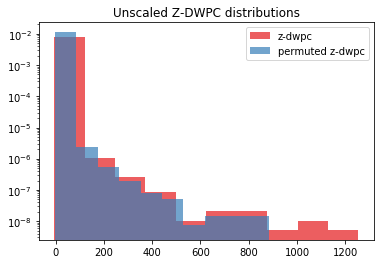

In [28]:
plt.hist(dwpc_df.dropna()[dwpc_df['z-dwpc'] != np.inf]['z-dwpc'], color=c1, alpha=0.7, density=True, label='z-dwpc');
plt.hist(df.dropna()[df['z-dwpc'] != np.inf]['z-dwpc'], color=c2, alpha=0.7, density=True, label='permuted z-dwpc');
plt.yscale('log', nonposy='clip')
plt.title(f'Unscaled Z-DWPC distributions')
plt.legend();

### Scaled DWPC values

In [29]:
scaler = dwpc_values.mean()
scaler

0.0001533989229588653

In [30]:
scaled_dwpc = np.arcsinh(dwpc_values / scaler)

In [31]:
scaled_perms = np.arcsinh(perms / scaler)

In [32]:
sum_scaled_perms = scaled_perms.sum(axis=1)

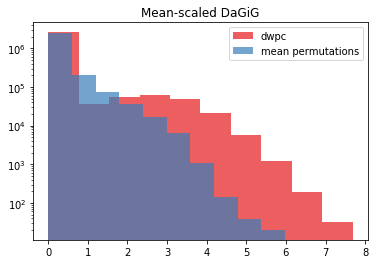

In [33]:
# Path mean DWPC across all permutations
mean_scaled_values = np.mean(scaled_perms, axis=1)

plt.hist(scaled_dwpc, color=c1, label='dwpc', alpha=0.7)
plt.hist(mean_scaled_values, color=c2, label='mean permutations', alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.title(f'Mean-scaled {metapath}')
plt.legend();

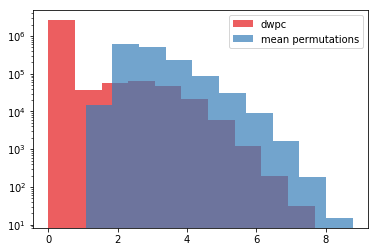

In [34]:
# Scale the sum of permuted DWPC by the NNZ permutations for that path
mean_scaled_values = sum_scaled_perms[path_nnz != 0] / path_nnz[path_nnz != 0]

plt.hist(scaled_dwpc, color=c1, label='dwpc', alpha=0.7)
plt.hist(mean_scaled_values, color=c2, label='mean permutations', alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.legend()

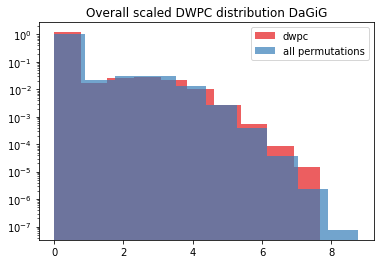

In [35]:
# Normalized histogram of all DWPC values for hetionet and all 45 permutations
plt.hist(scaled_dwpc, color=c1, density=True, alpha=0.7, label='dwpc')
plt.hist(scaled_perms.flatten(), color=c2, density=True, alpha=0.7, label='all permutations')
plt.yscale('log', nonposy='clip')
plt.title(f'Overall scaled DWPC distribution {metapath}')
plt.legend();

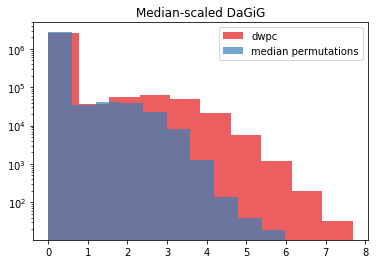

In [36]:
# Path median DWPC across all permutations
mean_scaled_values = np.median(scaled_perms, axis=1)

plt.hist(scaled_dwpc, color=c1, label='dwpc', alpha=0.7)
plt.hist(mean_scaled_values, color=c2, label='median permutations', alpha=0.7)
plt.yscale('log', nonposy='clip')
plt.title(f'Median-scaled {metapath}')
plt.legend();

## Investigate P-DWPC

In [37]:
dwpc_df = pd.DataFrame(scaled_dwpc, columns=['dwpc'])
dwpc_df['p-dwpc'] = np.mean(scaled_perms, axis=1)
dwpc_df['r-dwpc'] = dwpc_df['dwpc'] - dwpc_df['p-dwpc']
dwpc_df['sd-dwpc'] = np.std(scaled_perms, axis=1)
dwpc_df['z-dwpc'] = dwpc_df['r-dwpc'] / dwpc_df['sd-dwpc']

dwpc_df = dwpc_df[dwpc_df['z-dwpc'] != np.inf].dropna()

In [38]:
perm_df = pd.DataFrame(scaled_perms.T[0], columns=['dwpc'])
perm_df['p-dwpc'] = np.mean(scaled_perms.T[1:], axis=0)
perm_df['r-dwpc'] = perm_df['dwpc'] - perm_df['p-dwpc']
perm_df['sd-dwpc'] = np.std(scaled_perms.T[1:], axis=0)
perm_df['z-dwpc'] = perm_df['r-dwpc'] / perm_df['sd-dwpc']

perm_df = perm_df[perm_df['z-dwpc'] != np.inf].dropna()

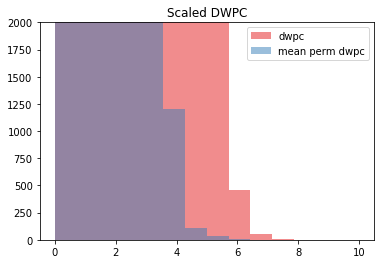

In [39]:
plt.hist(dwpc_df['dwpc'], color=c1, label='dwpc', bins=np.linspace(0,10,15), alpha=0.5)
plt.hist(dwpc_df['p-dwpc'], color=c2, label='mean perm dwpc', bins=np.linspace(0,10,15), alpha=0.5)
plt.title('Scaled DWPC')
plt.ylim((0, 2000))
# plt.xlim((0, 20))
plt.legend();

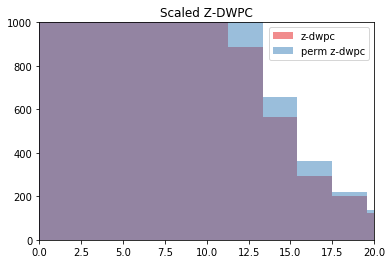

In [40]:
plt.hist(dwpc_df['z-dwpc'], color=c1, label='z-dwpc', bins=np.linspace(-20,30,25), alpha=0.5)
plt.hist(perm_df['z-dwpc'], color=c2, label='perm z-dwpc', bins=np.linspace(-20,30,25), alpha=0.5)
plt.title('Scaled Z-DWPC')
plt.ylim((0, 1000))
plt.xlim((0, 20))
plt.legend();

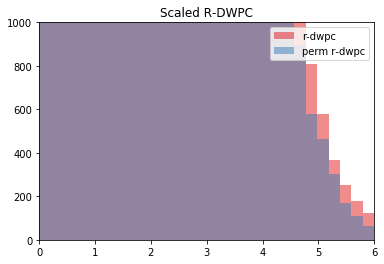

In [41]:
plt.hist(dwpc_df['r-dwpc'], color=c1, label='r-dwpc', bins=np.linspace(-4,6,50), alpha=0.5)
plt.hist(perm_df['r-dwpc'], color=c2, label='perm r-dwpc', bins=np.linspace(-4,6,50), alpha=0.5)
plt.title('Scaled R-DWPC')
plt.ylim((0, 1000))
plt.xlim((0, 6))
plt.legend();

## Use degree-grouped permutations

In [42]:
dwpc_df = combine_dwpc_dgp(hetmat, metapath, hetmat)

In [43]:
dwpc_df.head()

,dwpc,path-count,source_id,source_name,target_id,target_name,n,nnz,n_perms,p-dwpc,sd-dwpc,r-dwpc,z-dwpc
0,0.0,0,DOID:0050156,idiopathic pulmonary fibrosis,1,A1BG,16350,485,25,0.097439,0.579813,-0.097439,-0.168053
1,0.0,0,DOID:0050156,idiopathic pulmonary fibrosis,177,AGER,16350,485,25,0.097439,0.579813,-0.097439,-0.168053
2,0.0,0,DOID:0050156,idiopathic pulmonary fibrosis,182,JAG1,16350,485,25,0.097439,0.579813,-0.097439,-0.168053
3,0.0,0,DOID:0050156,idiopathic pulmonary fibrosis,197,AHSG,16350,485,25,0.097439,0.579813,-0.097439,-0.168053
4,0.0,0,DOID:0050156,idiopathic pulmonary fibrosis,221,ALDH3B1,16350,485,25,0.097439,0.579813,-0.097439,-0.168053


In [44]:
_ = pipeline.compute_save_dwpc(hetmat.permutations['043'], hetmat.metagraph.get_metapath(metapath), damping=0)
_ = pipeline.compute_save_dwpc(hetmat.permutations['043'], hetmat.metagraph.get_metapath(metapath), damping=0.5)

In [45]:
perm_df = combine_dwpc_dgp(hetmat, metapath, hetmat.permutations['043'])

In [46]:
perm_df.head()

,dwpc,path-count,source_id,source_name,target_id,target_name,n,nnz,n_perms,p-dwpc,sd-dwpc,r-dwpc,z-dwpc
0,0.0,0.0,DOID:0050156,idiopathic pulmonary fibrosis,1,A1BG,16350,485,25,0.097439,0.579813,-0.097439,-0.168053
1,0.0,0.0,DOID:0050156,idiopathic pulmonary fibrosis,177,AGER,16350,485,25,0.097439,0.579813,-0.097439,-0.168053
2,0.0,0.0,DOID:0050156,idiopathic pulmonary fibrosis,182,JAG1,16350,485,25,0.097439,0.579813,-0.097439,-0.168053
3,0.0,0.0,DOID:0050156,idiopathic pulmonary fibrosis,197,AHSG,16350,485,25,0.097439,0.579813,-0.097439,-0.168053
4,0.0,0.0,DOID:0050156,idiopathic pulmonary fibrosis,221,ALDH3B1,16350,485,25,0.097439,0.579813,-0.097439,-0.168053


Text(0.5,1,'Comparison of Z-DWPC distributions along DaGiG')

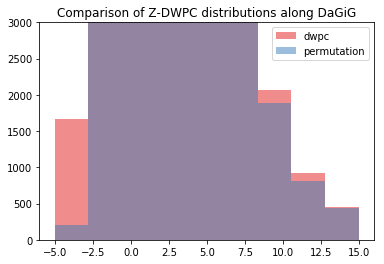

In [47]:
bins = np.linspace(-5,15,10)

plt.hist(dwpc_df['z-dwpc'].dropna(), alpha=0.5, label='dwpc', color=c1, bins=bins);
plt.hist(perm_df['z-dwpc'].dropna(), alpha=0.5, label='permutation', color=c2, bins=bins);
plt.legend();
plt.ylim((0, 3000))
plt.title(f'Comparison of Z-DWPC distributions along {metapath}')

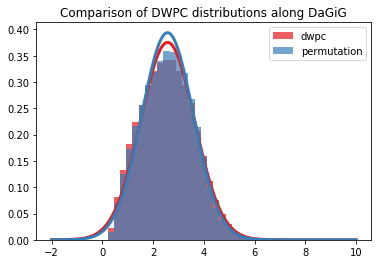

In [48]:
# Approximate DWPC using the normal distribution
dwpc_mu, dwpc_sig = scipy.stats.norm.fit(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'])
perm_mu, perm_sig = scipy.stats.norm.fit(perm_df[perm_df['dwpc'] > 0]['dwpc'])

x = np.linspace(-2,10,1000)
dwpc_y = scipy.stats.norm.pdf(x, loc=dwpc_mu, scale=dwpc_sig)
perm_y = scipy.stats.norm.pdf(x, loc=perm_mu, scale=perm_sig)

# Make figure
bins = np.linspace(-2, 10, 50)

plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='dwpc', color=c1, bins=bins, density=True)
plt.hist(perm_df[perm_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='permutation', color=c2, bins=bins, density=True);

plt.plot(x, dwpc_y, color=c1, linewidth=3)
plt.plot(x, perm_y, color=c2, linewidth=3)

plt.legend();
# plt.ylim((0, 0.6))
plt.title(f'Comparison of DWPC distributions along {metapath}');

## Distributions of permuted DWPC using degree-grouping -> How close to normal?

In [49]:
dwpc_df[(dwpc_df['nnz'] < 25) & (dwpc_df['dwpc'] != 0)]

,dwpc,path-count,source_id,source_name,target_id,target_name,n,nnz,n_perms,p-dwpc,sd-dwpc,r-dwpc,z-dwpc
26464,2.053369,1,DOID:0050156,idiopathic pulmonary fibrosis,25,ABL1,50,22,25,0.907067,1.224545,1.146301,0.936104
33020,1.390019,1,DOID:0050156,idiopathic pulmonary fibrosis,60,ACTB,50,20,25,0.919828,1.275343,0.470191,0.368678
40459,2.743262,1,DOID:13189,gout,836,CASP3,50,21,25,1.057928,1.399259,1.685334,1.204447
40962,1.394247,1,DOID:0050156,idiopathic pulmonary fibrosis,1499,CTNNB1,50,23,25,0.992982,1.202995,0.401265,0.333555
41346,1.504298,1,DOID:0050156,idiopathic pulmonary fibrosis,2932,GSK3B,50,24,25,1.006075,1.323768,0.498223,0.376367
41764,3.110815,1,DOID:0050156,idiopathic pulmonary fibrosis,6310,ATXN1,50,23,25,1.081247,1.335977,2.029568,1.519163
41808,2.263989,1,DOID:0050156,idiopathic pulmonary fibrosis,7323,UBE2D3,50,13,25,0.613857,1.203063,1.650132,1.371609
41820,2.916441,2,DOID:0050156,idiopathic pulmonary fibrosis,7431,VIM,50,19,25,0.831768,1.206727,2.084674,1.727543
41889,4.506793,1,DOID:13189,gout,388677,NOTCH2NL,50,23,25,0.995451,1.242836,3.511342,2.825267
99723,1.827442,1,DOID:986,alopecia areata,302,ANXA2,75,19,25,0.567818,1.084976,1.259624,1.160969


$\forall$ path $p_i$, DWPC values along the path among permutations are randomly distributed according to some distribution $G_{p_i}$ with parameters $\theta_1, ..., \theta_n$ and $m_j$, the metapath.

$\mathrm{DWPC}_{p_i} \sim G_{p_i}(\theta_1, ..., \theta_n, m_j)$

Within a permutation, $M_k$, individual DWPCs along metapath $m_j$ are approximately normally distributed.

$\mathrm{DWPC}_{M_k, m_j} \sim N(\mu_{m_j}, \sigma_{m_j}^2)$

In [50]:
dwpc_df['adjusted-p-dwpc'] = dwpc_df['p-dwpc'] * dwpc_df['n'] / dwpc_df['nnz']

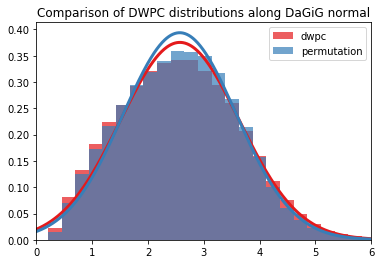

In [51]:
# Approximate DWPC using the normal distribution
dwpc_mu, dwpc_sig = scipy.stats.norm.fit(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'])
perm_mu, perm_sig = scipy.stats.norm.fit(perm_df[perm_df['dwpc'] > 0]['dwpc'])
p_mu, p_sig = scipy.stats.norm.fit(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'])

x = np.linspace(-2,10,1000)
dwpc_y = scipy.stats.norm.pdf(x, loc=dwpc_mu, scale=dwpc_sig)
perm_y = scipy.stats.norm.pdf(x, loc=perm_mu, scale=perm_sig)
p_y = scipy.stats.norm.pdf(x, loc=p_mu, scale=p_sig)

# Make figure
bins = np.linspace(-2, 10, 50)

plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='dwpc', color=c1, bins=bins, density=True)
plt.hist(perm_df[perm_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='permutation', color=c2, bins=bins, density=True);
# plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'].dropna(), alpha=0.7, label='p-dwpc', color=c3, bins=bins, density=True)

plt.plot(x, dwpc_y, color=c1, linewidth=3)
plt.plot(x, perm_y, color=c2, linewidth=3)
# plt.plot(x, p_y, color=c3, linewidth=3)

plt.legend();
# plt.ylim((0, 0.6))
plt.xlim((0, 6))
plt.title(f'Comparison of DWPC distributions along {metapath} normal');

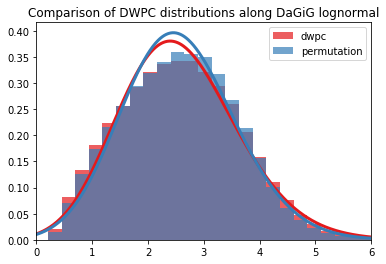

In [52]:
# Approximate DWPC using the lognormal distribution
dwpc_s, dwpc_mu, dwpc_sig = scipy.stats.lognorm.fit(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'])
perm_s, perm_mu, perm_sig = scipy.stats.lognorm.fit(perm_df[perm_df['dwpc'] > 0]['dwpc'])
p_s, p_mu, p_sig = scipy.stats.lognorm.fit(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'])

x = np.linspace(-2,10,1000)
dwpc_y = scipy.stats.lognorm.pdf(x, dwpc_s, loc=dwpc_mu, scale=dwpc_sig)
perm_y = scipy.stats.lognorm.pdf(x, perm_s, loc=perm_mu, scale=perm_sig)
p_y = scipy.stats.lognorm.pdf(x, p_s, loc=p_mu, scale=p_sig)

# Make figure
bins = np.linspace(-2, 10, 50)

plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='dwpc', color=c1, bins=bins, density=True)
plt.hist(perm_df[perm_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='permutation', color=c2, bins=bins, density=True);
# plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'].dropna(), alpha=0.7, label='p-dwpc', color=c3, bins=bins, density=True)

plt.plot(x, dwpc_y, color=c1, linewidth=3)
plt.plot(x, perm_y, color=c2, linewidth=3)
# plt.plot(x, p_y, color=c3, linewidth=3)

plt.legend();
# plt.ylim((0, 0.6))
plt.xlim((0, 6))
plt.title(f'Comparison of DWPC distributions along {metapath} lognormal');

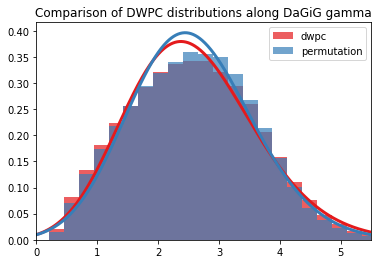

In [53]:
# Approximate DWPC using the gamma distribution
dwpc_a, dwpc_gamma_mu, dwpc_gamma_sig = scipy.stats.gamma.fit(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'])
perm_a, perm_mu, perm_sig = scipy.stats.gamma.fit(perm_df[perm_df['dwpc'] > 0]['dwpc'])
p_a, p_mu, p_sig = scipy.stats.gamma.fit(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'])

x = np.linspace(-2,10,1000)
dwpc_y = scipy.stats.gamma.pdf(x, dwpc_a, loc=dwpc_gamma_mu, scale=dwpc_gamma_sig)
perm_y = scipy.stats.gamma.pdf(x, perm_a, loc=perm_mu, scale=perm_sig)
p_y = scipy.stats.gamma.pdf(x, p_a, loc=p_mu, scale=p_sig)

# Make figure
bins = np.linspace(-2, 10, 50)

plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='dwpc', color=c1, bins=bins, density=True)
plt.hist(perm_df[perm_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='permutation', color=c2, bins=bins, density=True);
# plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'].dropna(), alpha=0.7, label='p-dwpc', color=c3, bins=bins, density=True)

plt.plot(x, dwpc_y, color=c1, linewidth=3)
plt.plot(x, perm_y, color=c2, linewidth=3)
# plt.plot(x, p_y, color=c3, linewidth=3)

plt.legend();
# plt.ylim((0, 0.6))
plt.xlim((0, 5.5))
plt.title(f'Comparison of DWPC distributions along {metapath} gamma');

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


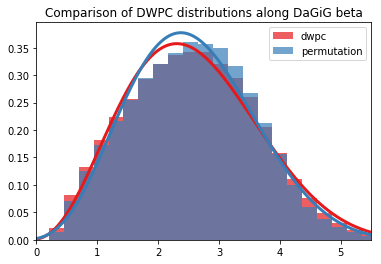

In [54]:
# Approximate DWPC using the beta distribution
dwpc_beta_a, dwpc_beta_b, dwpc_beta_mu, dwpc_beta_sig = scipy.stats.beta.fit(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'].dropna())
perm_a, perm_b, perm_mu, perm_sig = scipy.stats.beta.fit(perm_df[perm_df['dwpc'] > 0]['dwpc'].dropna())
p_a, p_b, p_mu, p_sig = scipy.stats.beta.fit(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'].dropna())

x = np.linspace(-2,10,1000)
dwpc_y = scipy.stats.beta.pdf(x, dwpc_beta_a, dwpc_beta_b, loc=dwpc_beta_mu, scale=dwpc_beta_sig)
perm_y = scipy.stats.beta.pdf(x, perm_a, perm_b, loc=perm_mu, scale=perm_sig)
p_y = scipy.stats.beta.pdf(x, p_a, p_b, loc=p_mu, scale=p_sig)

# Make figure
bins = np.linspace(-2, 10, 50)

plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='dwpc', color=c1, bins=bins, density=True)
plt.hist(perm_df[perm_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='permutation', color=c2, bins=bins, density=True);
# plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'].dropna(), alpha=0.7, label='p-dwpc', color=c3, bins=bins, density=True)

plt.plot(x, dwpc_y, color=c1, linewidth=3)
plt.plot(x, perm_y, color=c2, linewidth=3)
# plt.plot(x, p_y, color=c3, linewidth=3)

plt.legend();
# plt.ylim((0, 0.6))
plt.xlim((0, 5.5))
plt.title(f'Comparison of DWPC distributions along {metapath} beta');

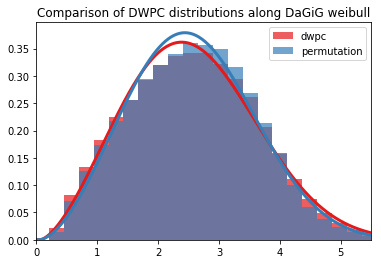

In [55]:
# Approximate DWPC using the weibull distribution
dwpc_a, dwpc_gamma_mu, dwpc_gamma_sig = scipy.stats.weibull_min.fit(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'])
perm_a, perm_mu, perm_sig = scipy.stats.weibull_min.fit(perm_df[perm_df['dwpc'] > 0]['dwpc'])
p_a, p_mu, p_sig = scipy.stats.weibull_min.fit(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'])

x = np.linspace(-2,10,1000)
dwpc_y = scipy.stats.weibull_min.pdf(x, dwpc_a, loc=dwpc_gamma_mu, scale=dwpc_gamma_sig)
perm_y = scipy.stats.weibull_min.pdf(x, perm_a, loc=perm_mu, scale=perm_sig)
p_y = scipy.stats.weibull_min.pdf(x, p_a, loc=p_mu, scale=p_sig)

# Make figure
bins = np.linspace(-2, 10, 50)

plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='dwpc', color=c1, bins=bins, density=True)
plt.hist(perm_df[perm_df['dwpc'] > 0]['dwpc'].dropna(), alpha=0.7, label='permutation', color=c2, bins=bins, density=True);
# plt.hist(dwpc_df[dwpc_df['dwpc'] > 0]['adjusted-p-dwpc'].dropna(), alpha=0.7, label='p-dwpc', color=c3, bins=bins, density=True)

plt.plot(x, dwpc_y, color=c1, linewidth=3)
plt.plot(x, perm_y, color=c2, linewidth=3)
# plt.plot(x, p_y, color=c3, linewidth=3)

plt.legend();
# plt.ylim((0, 0.6))
plt.xlim((0, 5.5))
plt.title(f'Comparison of DWPC distributions along {metapath} weibull');

Potentially should correct for the differences between permutations in the distributions of DWPC values

In [56]:
np.mean(path_nnz) / 45

0.25174676580245214

In [57]:
np.count_nonzero(path_nnz) / len(path_nnz)

0.528224599359114

(array([0.04815745, 0.0114784 , 0.00645115, 0.00374202, 0.00262868,
        0.00211998, 0.00152924, 0.00138298, 0.00113073, 0.00202453]),
 array([  1. ,  13.4,  25.8,  38.2,  50.6,  63. ,  75.4,  87.8, 100.2,
        112.6, 125. ]),
 <a list of 10 Patch objects>)

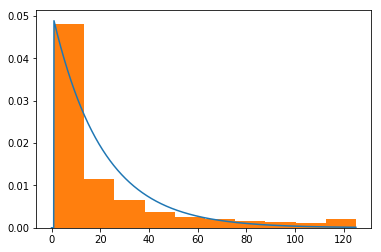

In [71]:
x = np.linspace(0, 125, 1000)
loc, scale = scipy.stats.expon.fit(path_nnz[path_nnz != 0])
y = scipy.stats.expon.pdf(x, loc=loc, scale=scale)

plt.plot(x, y)
plt.hist(path_nnz[path_nnz != 0], density=True)
# plt.ylim((0, 0.2))

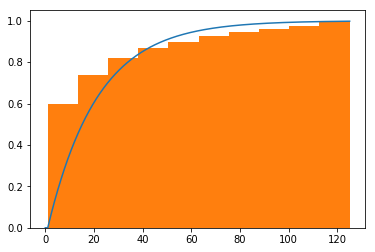

In [72]:
y = scipy.stats.expon.cdf(x, loc=loc, scale=scale)

plt.plot(x, y)
plt.hist(path_nnz[path_nnz != 0], density=True, cumulative=True);

In [75]:
x = np.linspace(0, 125, 1000)
a, b, mu, sig = scipy.stats.beta.fit(path_nnz[path_nnz != 0])
y = scipy.stats.beta.cdf(x, a, b, mu, sig)

plt.plot(x, y)
plt.hist(path_nnz[path_nnz != 0], density=True)
# plt.ylim((0, 0.2))

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


KeyboardInterrupt: 

In [76]:
a, b , mu, sig

(0.38723962885917157,
 1.7114124270797375,
 0.9999999999999999,
 186.91654361666872)

## Distribution of degree-grouped permutations

In [60]:
p_nonzero = len(dwpc_df[dwpc_df['dwpc'] != 0]) / len(dwpc_df)

In [61]:
dgp_path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5', 
                                     'degree-grouped-permutations', 
                                     f'{metapath}.tsv')

In [62]:
dgp_df = pd.read_table(dgp_path)

In [63]:
dgp_df.head(2)

,source_degree,target_degree,n,nnz,n_perms,mean,sd
0,0,0,433500,0,25,0.0,0.0
1,0,1,186225,0,25,0.0,0.0


In [64]:
dwpc_df[(dwpc_df['nnz'] == 0) & (dwpc_df['dwpc'] != 0)]

,dwpc,path-count,source_id,source_name,target_id,target_name,n,nnz,n_perms,p-dwpc,sd-dwpc,r-dwpc,z-dwpc,adjusted-p-dwpc


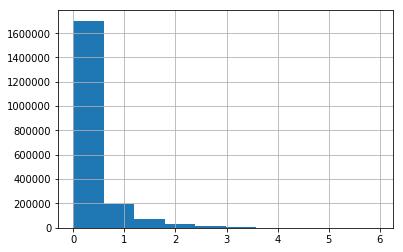

In [65]:
dwpc_df[dwpc_df['p-dwpc'] != 0]['p-dwpc'].hist()

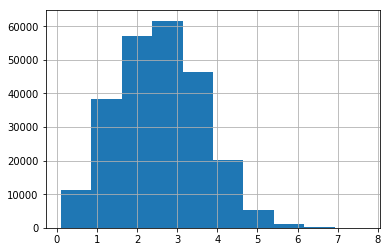

In [66]:
dwpc_df[dwpc_df['dwpc'] != 0]['dwpc'].hist()

In [67]:
def model_dwpc_normal(n=1):
    draws = []
    for i in range(n):
        draw = np.random.rand()
        if draw < p_nonzero:
            draw = np.random.normal(loc=dwpc_mu, scale=dwpc_sig)
        else:
            draw = 0
        draws.append(draw)
    return pd.DataFrame(draws)


def model_dwpc_gamma(n=1):
    draws = []
    for i in range(n):
        draw = np.random.rand()
        if draw < p_nonzero:
            draw = scipy.stats.gamma.rvs(a=dwpc_a, loc=dwpc_gamma_mu, scale=dwpc_gamma_sig)
        else:
            draw = 0
        draws.append(draw)
    return pd.DataFrame(draws)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe099118780>]],
      dtype=object)

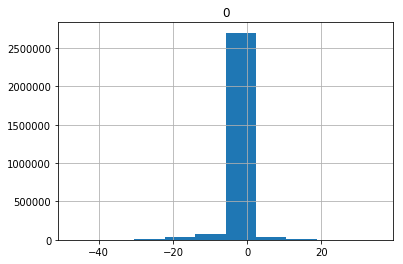

In [68]:
model_dwpc_normal(len(dwpc_df)).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe098795470>]],
      dtype=object)

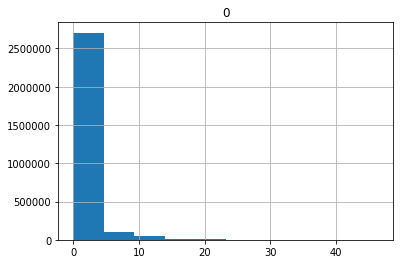

In [69]:
model_dwpc_gamma(len(dwpc_df)).hist()

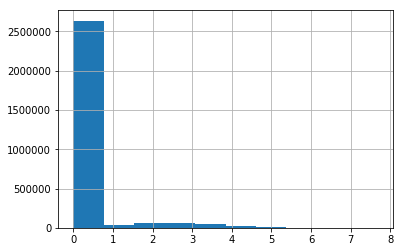

In [70]:
dwpc_df['dwpc'].hist()